In [1]:
#Packages
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import exposure #for pre and post processing 
import mahotas#for seeded watershed
import os
import skimage
import csv
import statistics

In [17]:
class Image_processing():
    def __init__(self,image,path) :
        self.image = image
        self.path = path
        self.duplicate()
        self.gamma_correction()
        self.split_channel()
        self.close_holes()
        self.convert_to_gray()
        self.get_cells() #Store output in folder Indivisual_Cells
        self.run_func()
        self.plot_histogram('35_0gy_2h_p6')
        self.plot_histogram('35_8gy_24h_p6')
        self.plot_box()
        
    
    def duplicate(self):
        #make copy of original image 
        self.original =self.image.copy()

    def gamma_correction(self):#apply gamma correction
        self.gamma_corrected = exposure.adjust_gamma(self.image, 0.32)
        #plt.imshow(self.gamma_corrected)

    def split_channel(self):
        #split channel #image_b, image_g, image_r = cv2.split(image_sample) #preprocessing
        #fro blue set green and red channels to 0
        self.gamma_corrected[:, :, 1] = 0
        self.gamma_corrected[:, :, 2] = 0
        #plt.imshow(self.gamma_corrected)

    def close_holes(self):
        kernel = np.ones((15,15),np.uint8)
        self.closed = cv2.morphologyEx(self.gamma_corrected, cv2.MORPH_CLOSE, kernel)
        #plt.imshow(self.closed)

    def convert_to_gray(self):
        # convert to RGB image and convert to float32
        self.closed = cv2.cvtColor(self.closed, cv2.COLOR_BGR2RGB)
        self.closed = self.closed.astype(np.float32) / 255.0
        # grayscale and blurring for canny edge detection
        self.gray = cv2.cvtColor(self.original, cv2.COLOR_BGR2GRAY)

    def thresholding(self):
        #gray = cv2.cvtColor(self.closed,cv2.COLOR_BGR2GRAY)
        #plt.imshow(gray)
        ret, thresh = cv2.threshold(self.gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        #plt.imshow(thresh)

    def canny_edge_detection(self):

        blurred = cv2.GaussianBlur(self.gray, (5, 5), 0)
        canny = cv2.Canny(blurred, 50, 200)# carry out Canny edge detection
        # initialize the structured edge detector with the model
        edge_detector = cv2.ximgproc.createStructuredEdgeDetection('model.yml')
        # detect the edges
        edges = edge_detector.detectEdges(self.closed)

        plt.imshow(canny)
        plt.show()
        plt.imshow(edges)
        plt.show()

        norm_image = cv2.normalize(edges, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)
        edges = norm_image.astype(np.uint8)
        gry=edges
        bw=cv2.threshold(gry, 5, 255, cv2.THRESH_BINARY)[1]

        # Use floodfill to identify outer shape of objects
        imFlood = bw.copy()
        h, w = bw.shape[:2]
        mask = np.zeros((h+2, w+2), np.uint8)
        cv2.floodFill(imFlood, mask, (0,0), 0)

        cnts, hierarchy = cv2.findContours(imFlood, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
        i=0
        for cnt in cnts:
            # if the contour has no other contours inside of it
            if cv2.contourArea(cnt) > 500:
                peri = cv2.arcLength(cnt, True)
                approx = cv2.approxPolyDP(cnt, 0.02*peri, True)
                x, y, w, h = cv2.boundingRect(approx)
                bob = edges[y:y+h, x:x+w]
                cv2.rectangle(self.original, (x, y), (x+w, y+h), (0, 255, 0), 2)
            i=i+1

        plt.imshow(self.original) # to view bounding boxes 
        plt.show()


    def treshhold_otsu(self,image_channel):
        ret, self.image_treshhold = cv2.threshold(cv2.equalizeHist(image_channel), 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        
    def auto_treshhold(self,image_channel):
        thresh  = skimage.filters.threshold_yen(image_channel)
        thresh = image_channel <= thresh
        thresh = skimage.img_as_ubyte(thresh)
        thresh = cv2.bitwise_not(thresh)
        return thresh

    def watershed_seeded(self,image_treshhold,filter_rule):
        img_h, img_w = image_treshhold.shape
        threshed  = (image_treshhold > image_treshhold.mean())
        distances = mahotas.stretch(mahotas.distance(threshed))
        Bc = np.ones((20,20)) #structure element
        maxima = mahotas.morph.regmax(distances, Bc=Bc) #regional maxima
        spots,n_spots = mahotas.label(maxima, Bc=Bc)
        surface = (distances.max() - distances)
        areas = mahotas.cwatershed(surface, spots)
        areas *= threshed
        i=0
        for label in range(1, np.max(areas)):
            mask = np.zeros((img_h, img_w, 1), dtype="uint8") #Create mask
            mask[areas == label] = 255
            contours, hierarchy = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            for cnt in contours:
                M = cv2.moments(cnt) # compute the center of the contour
                if M["m00"] > 0:
                    _,_,width,height = cv2.boundingRect(cnt)
                    if(width > 25) or (height > 25) or (filter_rule == False): #Accept which have more than 25 pixel in either height or width
                        area = cv2.contourArea(cnt)  # calculate area of contour
                        peri = cv2.arcLength(cnt, True)
                        approx = cv2.approxPolyDP(cnt, 0.02*peri, True)
                        x, y, w, h = cv2.boundingRect(approx)
                        bob = self.original[y:y+h, x:x+w]
                        cv2.imwrite(os.path.join('C:/Users/'+ str(self.path) +'/DIBI_Project/Indivisual_cells' + str(i) + '.png'), bob)#save cells in folder 
                        i=i+1

    def get_cells(self):
        #cell detection pipeline
        image_b, image_g, image_r = cv2.split(self.original) #preprocessing
        image_treshhold_b = self.auto_treshhold(image_b)
        image_treshhold_r = self.auto_treshhold(image_r)
        image_treshhold_g = self.auto_treshhold(image_g)
        image_treshhold = cv2.bitwise_or(image_treshhold_b, image_treshhold_r)
        image_treshhold = cv2.bitwise_or(image_treshhold, image_treshhold_g) #merge
        self.watershed_seeded(image_treshhold,True) #find cells

    def distance_sq(self,left, right):
            """ Returns the square of the distance between left and right. """
            return (
                ((left[0] - right[0]) ** 2) +
                ((left[1] - right[1]) ** 2)
            )


    def get_distances(self,img_name):
               
        distances_red =[]
        distances_green = []
        distances_red_green = []

        for i in range(0,82):
            green_chromson_pos = []
            with open('C:/Users/'+ str(self.path) +'/DIBI_Project/'+ str(img_name) +'/EachCell_distance/green/Results'+ str(i) + '_green.csv') as csvfile:
                green = csv.reader(csvfile, delimiter=',')
                for row in green:
                    if row[0] == ' ':
                        continue
                    x = int(row[1])
                    y = int(row[2])
                    green_chromson_pos.append([x,y])

            red_chromson_pos = []
            with open('C:/Users/'+ str(self.path) +'/DIBI_Project/'+ str(img_name) +'/EachCell_distance/red/Results'+ str(i) + '_red.csv') as csvfile:
                red = csv.reader(csvfile, delimiter=',')
                for row in red:
                    if row[0] == ' ':
                        continue
                    x = int(row[1])
                    y = int(row[2])
                    red_chromson_pos.append([x,y])

            green_green_distances = []
            for i in range(len(green_chromson_pos)):
                for j in range(len(green_chromson_pos)):
                    if i==j:
                        continue
                    else:
                        green_green_distances.append(self.distance_sq(green_chromson_pos[i],green_chromson_pos[j]))
            
            try:
                distances_green.append(statistics.median(green_green_distances))
            except statistics.StatisticsError:
                distances_green.append(0)

            red_red_distances = []
            for i in range(len(red_chromson_pos)):
                for j in range(len(red_chromson_pos)):
                    if i==j:
                        continue
                    else:
                        red_red_distances.append(self.distance_sq(red_chromson_pos[i],red_chromson_pos[j]))
            try:
                distances_red.append(statistics.median(red_red_distances))
            except statistics.StatisticsError:
                distances_red.append(0)

            red_green_distances = []
            for i in range(len(green_chromson_pos)):
                for j in range(len(red_chromson_pos)):
                    red_green_distances.append(self.distance_sq(green_chromson_pos[i],red_chromson_pos[j]))
            try:
                distances_red_green.append(statistics.median(red_green_distances))
            except statistics.StatisticsError:
                distances_red_green.append(0)

        self.distances_red_green = np.array(distances_red_green)

        self.distances_red = np.array(distances_red)

        self.distances_green = np.array(distances_green)

        return self.distances_red , self.distances_green , self.distances_red_green

    def run_func(self):
        img_name1 ='35_0gy_2h_p6'
        img_name2 ='35_8gy_24h_p6'

        self.distances_red1 , self.distances_green1 , self.distances_red_green1 =  self.get_distances(img_name1)
        self.distances_red2 , self.distances_green2 , self.distances_red_green2 =  self.get_distances(img_name2)

    def plot_histogram(self,img_name):

        if img_name =='35_0gy_2h_p6':
            plt.title('Image : '+ str(img_name) +' , Red Green Distances')
            plt.hist(self.distances_red_green1, bins=np.arange(self.distances_red_green1.min(), self.distances_red_green1.max()+1))
            plt.savefig('C:/Users/'+ str(self.path) +'/DIBI_Project/graphs/histogram_Red_Green_Distances_'+ str(img_name)+'.png')
        
            plt.title('Image : '+ str(img_name) +' , Red Red Distances')
            plt.hist(self.distances_red_green1, bins=np.arange(self.distances_red_green1.min(), self.distances_red_green1.max()+1))
            plt.savefig('C:/Users/'+ str(self.path) +'/DIBI_Project/graphs/histogram_Red_Red_Distances_'+ str(img_name)+'.png')
        
            plt.title('Image : '+ str(img_name) +' , Green Green Distances')
            plt.hist(self.distances_red_green1, bins=np.arange(self.distances_red_green1.min(), self.distances_red_green1.max()+1))
            plt.savefig('C:/Users/'+ str(self.path) +'/DIBI_Project/graphs/histogram_Green_Green_Distances_'+ str(img_name)+'.png')
        else :
            plt.title('Image : '+ str(img_name) +' , Red Green Distances')
            plt.hist(self.distances_red_green2, bins=np.arange(self.distances_red_green2.min(), self.distances_red_green2.max()+1))
            plt.savefig('C:/Users/'+ str(self.path) +'/DIBI_Project/graphs/histogram_Red_Green_Distances_'+ str(img_name)+'.png')
        
            plt.title('Image : '+ str(img_name) +' , Red Red Distances')
            plt.hist(self.distances_red_green2, bins=np.arange(self.distances_red_green2.min(), self.distances_red_green2.max()+1))
            plt.savefig('C:/Users/'+ str(self.path) +'/DIBI_Project/graphs/histogram_Red_Red_Distances_'+ str(img_name)+'.png')
        
            plt.title('Image : '+ str(img_name) +' , Green Green Distances')
            plt.hist(self.distances_red_green2, bins=np.arange(self.distances_red_green2.min(), self.distances_red_green2.max()+1))
            plt.savefig('C:/Users/'+ str(self.path) +'/DIBI_Project/graphs/histogram_Green_Green_Distances_'+ str(img_name)+'.png')

    def plot_box(self):
        
        # Creating dataset
        np.random.seed(10)
        
        #data_1 = (217.5,177.5)
        #data_2 = (169.5,383.0)
        #data_3 = (256.5,321.75)


        data = [self.distances_red1 , self.distances_green1 , self.distances_red_green1 ,self.distances_red2 ,self.distances_green2 ,self.distances_red_green1 ]
        
        fig = plt.figure(figsize =(12, 7))
        
        # Creating axes instance
        ax = fig.add_axes([0, 0, 1, 1])
        
        # Creating plot
        bp = ax.boxplot(data,patch_artist=True)
        ax.set_xticklabels(['red_35_0gy_2h_p6', 'green_35_0gy_2h_p6',
                            'red_green_35_0gy_2h_p6','red_35_8gy_24h_p6', 'green_35_8gy_24h_p6',
                            'red_green_35_8gy_24h_p6'])
        
        colors = ['red', 'green',
                'blue', 'red', 'green',
                'blue']
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)

        #show plot
        #plt.show()
        plt.savefig('C:/Users/'+ str(self.path) +'/DIBI_Project/graphs/boxplot_comparison.png')

In [18]:
#read image
image = cv2.imread(r'C:\Users\niman\Desktop\DIBI_Project\35_0gy_2h_p6.tif')
path = 'niman/Desktop'#give path like this 

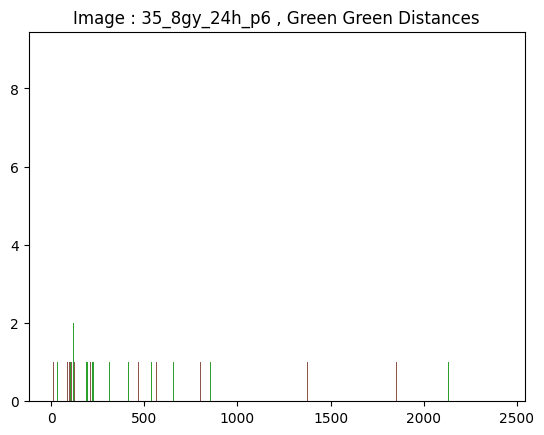

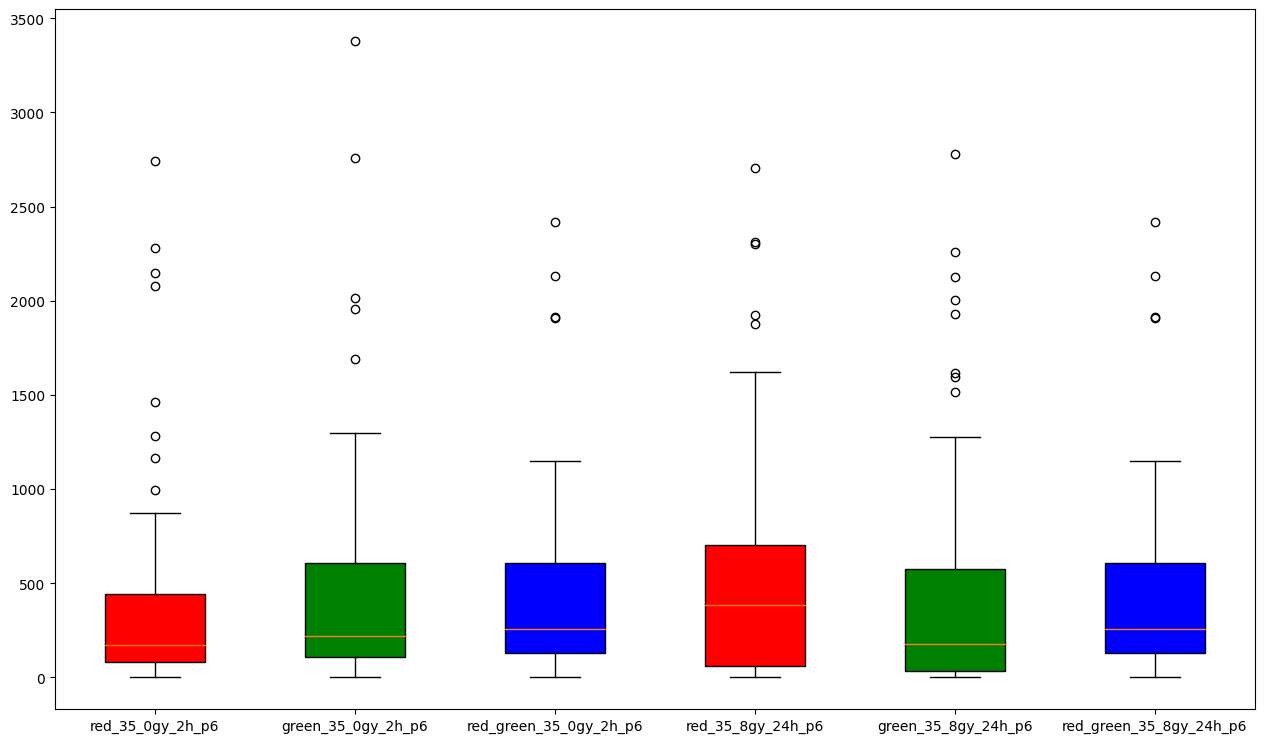

In [19]:
obj1=Image_processing(image,path)